In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Load the data
from uwv.config import CBS80072NED, CBS_OPENDATA_PROCESSED_DATA_DIR, OUTPUT_DIR

cbs = pd.read_parquet(CBS_OPENDATA_PROCESSED_DATA_DIR / f"{CBS80072NED}.parquet")

2024-08-23 12:57:42.091 | INFO     | uwv.config:<module>:11 - PROJ_ROOT path is: C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv


In [4]:
# Filter out rows where 'period_quarter_number' is 0
cbs = cbs[cbs['period_quarter_number'] != 0]

# Map quarters to months and create the 'date' column
cbs['month'] = cbs['period_quarter_number'].map({1: 1, 2: 4, 3: 7, 4: 10})
cbs['date'] = pd.to_datetime({'year': cbs['period_year'], 'month': cbs['month'], 'day': 1})

# Set this new 'date' column as the index
cbs.set_index('date', inplace=True)

In [5]:
# Filter data based on 'sbi_title'
sbi_code = 'T001081'  # Example: A-U Alle economische activiteiten
filtered_cbs = cbs[cbs['sbi'] == sbi_code]

# Filter the data to include only dates from 2016 to 2023
filtered_cbs = filtered_cbs.loc['2016-01-01':'2023-12-31']

In [6]:
# Step 1: Define the training and testing data
train_data = filtered_cbs.iloc[:-8]  # Use all but the last 8 quarters (2 years) for training
test_data = filtered_cbs.iloc[-8:]   # Use the last 8 quarters (2 years) for testing

In [7]:
# Step 2: Fit the Holt-Winters Exponential Smoothing model
fitted_model = ExponentialSmoothing(train_data['sick_leave_percentage'],
                                    trend='mul', seasonal='mul', seasonal_periods=4).fit()

c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [8]:
# Step 3: Forecast the next 8 quarters
test_predictions = fitted_model.forecast(8).rename('HW Forecast')

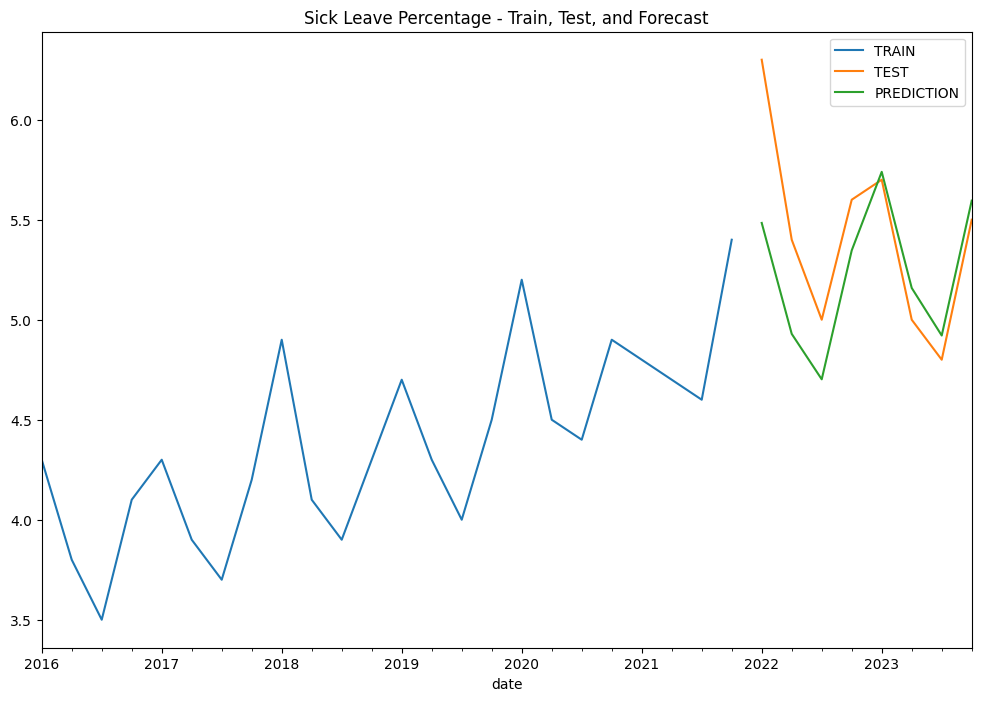

In [9]:
# Step 4: Plot the training, testing, and forecasted data
plt.figure(figsize=(12, 8))
train_data['sick_leave_percentage'].plot(legend=True, label='TRAIN')
test_data['sick_leave_percentage'].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION')
plt.title('Sick Leave Percentage - Train, Test, and Forecast')
plt.show()

In [10]:
# Step 5: Evaluate the forecast accuracy
mae = mean_absolute_error(test_data['sick_leave_percentage'], test_predictions)
mse = mean_squared_error(test_data['sick_leave_percentage'], test_predictions)
rmse = np.sqrt(mse)

In [11]:
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 0.2816278802398162
Mean Squared Error: 0.13639837584750134
Root Mean Squared Error: 0.36932150742611963


In [12]:
# Step 6: Fit the model to the entire dataset and forecast future values
final_model = ExponentialSmoothing(filtered_cbs['sick_leave_percentage'],
                                   trend='mul', seasonal='mul', seasonal_periods=4).fit()


c:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\uwv\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [13]:
# Forecast the next 8 quarters
forecast_predictions = final_model.forecast(8)

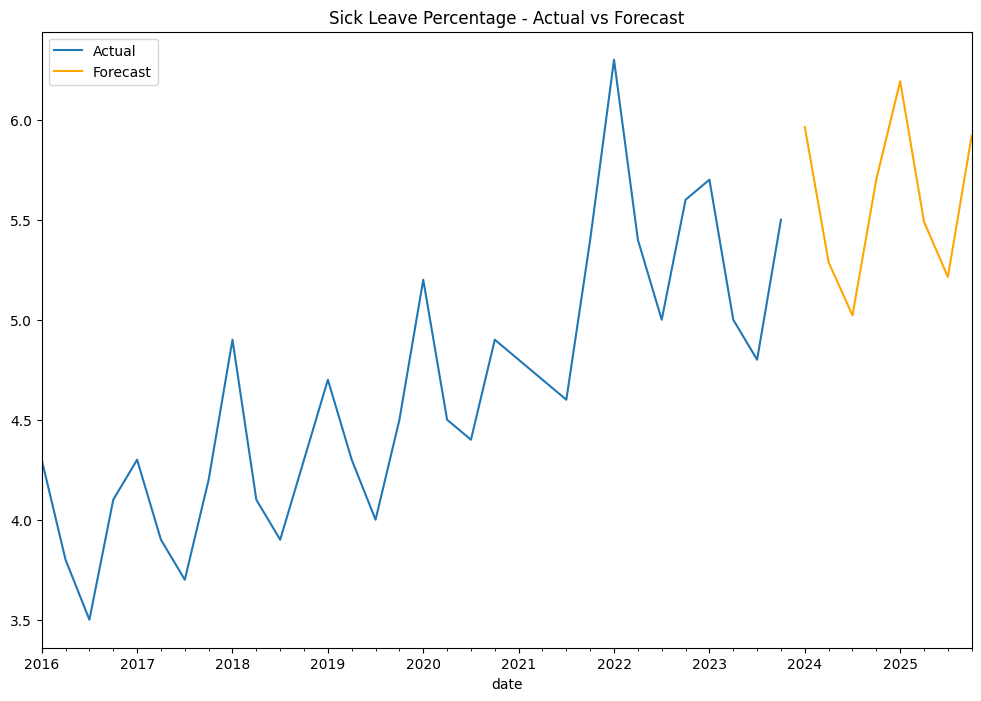

In [14]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 8))
filtered_cbs['sick_leave_percentage'].plot(label='Actual', figsize=(12, 8))
forecast_predictions.plot(label='Forecast', color='orange')
plt.title('Sick Leave Percentage - Actual vs Forecast')
plt.legend()
plt.show()